# **Kelompok 8 2023 A**

Nailah Masruroh 		(23031554100)

Tutik Hidayah Hardiyanti 	(23031554156)

Yulia Eka Restania 	(23031554199)

In [ ]:
from google.colab import files
files.upload()

# Install Kaggle library
!pip install -q kaggle

# Buat direktori untuk menyimpan kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dan unzip dataset Grapevine Leaves
!kaggle datasets download -d muratkokludataset/grapevine-leaves-image-dataset
!unzip grapevine-leaves-image-dataset.zip -d grapevine_dataset

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset
License(s): CC0-1.0
grapevine-leaves-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  grapevine-leaves-image-dataset.zip
replace grapevine_dataset/Grapevine_Leaves_Image_Dataset/Ak/Ak (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageStat
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tqdm import tqdm
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# ***Preprocessing***

In [ ]:
dataset_path = Path("grapevine_dataset/Grapevine_Leaves_Image_Dataset")
class_names = sorted([folder.name for folder in dataset_path.iterdir() if folder.is_dir()])
print("Kelas yang tersedia:", class_names)

Kelas yang tersedia: ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']


In [ ]:
image_data = []

for class_name in class_names:
    class_folder = dataset_path / class_name
    image_files = list(class_folder.glob("*.*"))

    for img_path in image_files:
        try:
            with Image.open(img_path) as img:
                image_data.append({
                    "class": class_name,
                    "width": img.width,
                    "height": img.height
                })
        except:
            print(f"Error reading: {img_path}")

# Convert ke DataFrame
df = pd.DataFrame(image_data)

# Jumlah gambar per kelas
print("Jumlah gambar per kelas:")
print(df['class'].value_counts(), "\n")

# Ukuran gambar
print("Ukuran gambar (rata-rata):")
print(df.groupby('class')[['width', 'height']].mean())


Jumlah gambar per kelas:
class
Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: count, dtype: int64 

Ukuran gambar (rata-rata):
           width  height
class                   
Ak         511.0   511.0
Ala_Idris  511.0   511.0
Buzgulu    511.0   511.0
Dimnit     511.0   511.0
Nazli      511.0   511.0


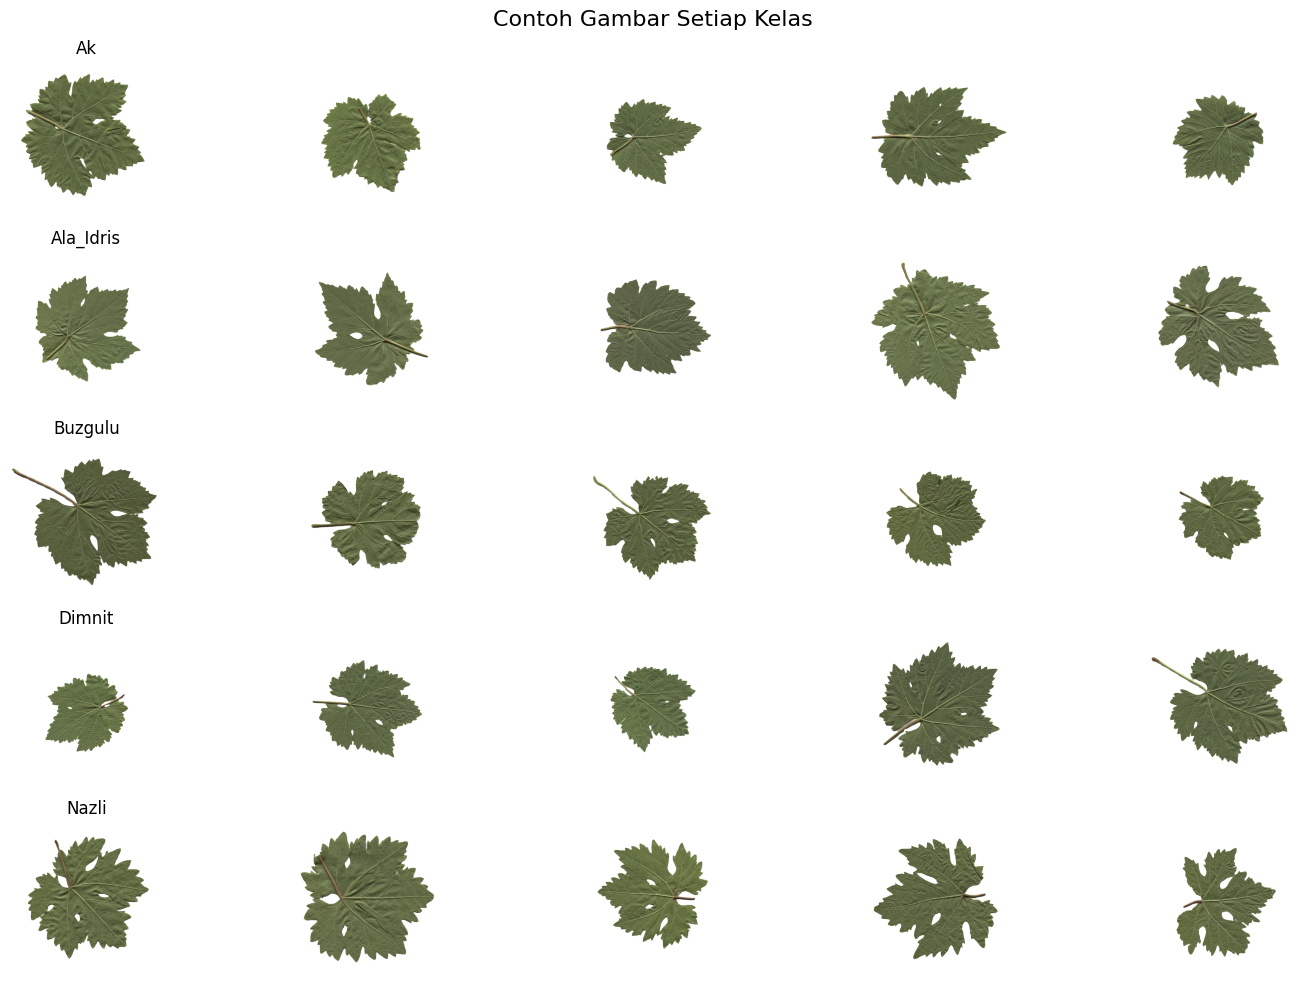

In [ ]:
plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(class_names):
    class_folder = dataset_path / class_name
    image_files = list(class_folder.glob("*.*"))

    for i in range(5):
        img = Image.open(image_files[i])
        plt.subplot(len(class_names), 5, idx*5 + i + 1)
        plt.imshow(img)
        plt.title(f"{class_name}" if i == 0 else "")
        plt.axis("off")

plt.suptitle("Contoh Gambar Setiap Kelas", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_image_quality(img_path):
    img_pil = Image.open(img_path).convert('RGB')
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2GRAY)

    # Brightness: rata-rata pixel
    stat = ImageStat.Stat(img_pil)
    brightness = sum(stat.mean) / len(stat.mean)

    # Sharpness: varian dari laplacian
    sharpness = cv2.Laplacian(img_cv, cv2.CV_64F).var()

    # Orientation: landscape, portrait, atau square
    w, h = img_pil.size
    if w > h:
        orientation = "Landscape"
    elif h > w:
        orientation = "Portrait"
    else:
        orientation = "Square"

    return brightness, sharpness, orientation

quality_data = []

for class_name in class_names:
    class_folder = dataset_path / class_name
    image_files = list(class_folder.glob("*.*"))

    for img_path in image_files:
        try:
            brightness, sharpness, orientation = evaluate_image_quality(img_path)
            quality_data.append({
                "class": class_name,
                "file": img_path.name,
                "brightness": brightness,
                "sharpness": sharpness,
                "orientation": orientation
            })
        except:
            print(f"Error processing {img_path}")

quality_df = pd.DataFrame(quality_data)

# Statistik umum
print("\nStatistik Brightness:")
print(quality_df['brightness'].describe())

print("\nStatistik Sharpness:")
print(quality_df['sharpness'].describe())

print("\nDistribusi Orientasi:")
print(quality_df['orientation'].value_counts())


Statistik Brightness:
count    500.000000
mean     202.245963
std       17.596545
min      153.025287
25%      190.556785
50%      204.030093
75%      215.659036
max      239.635136
Name: brightness, dtype: float64

Statistik Sharpness:
count     500.000000
mean      555.052256
std       173.639956
min       169.149222
25%       434.249652
50%       539.797492
75%       648.562632
max      1089.130472
Name: sharpness, dtype: float64

Distribusi Orientasi:
orientation
Square    500
Name: count, dtype: int64


In [ ]:
# Koreksi pencahayaan
def adjust_lighting(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    v = hsv[:, :, 2]
    brightness = np.mean(v)

    if brightness < 80:
        hsv[:, :, 2] = cv2.add(v, 50)
    elif brightness > 200:
        hsv[:, :, 2] = cv2.subtract(v, 50)

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Deteksi blur
def is_blurry(img, threshold=100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return var < threshold

# Sharpen jika blur
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Pipeline pengecekan & perbaikan
def quality_check_and_fix(img):
    img = adjust_lighting(img)
    if is_blurry(img):
        img = sharpen_image(img)
    return img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_path = Path("grapevine_dataset/Grapevine_Leaves_Image_Dataset")
output_path = Path("/content/drive/MyDrive/pcd_data/data_perbaikan")

# Buat folder tujuan jika belum ada
output_path.mkdir(parents=True, exist_ok=True)

# Proses tiap gambar
for class_folder in tqdm(list(source_path.iterdir()), desc="Processing Classes"):
    if class_folder.is_dir():
        class_name = class_folder.name
        target_class_folder = output_path / class_name
        target_class_folder.mkdir(parents=True, exist_ok=True)

        for img_path in class_folder.glob("*.png"):
            img = cv2.imread(str(img_path))
            if img is not None:
                fixed_img = quality_check_and_fix(img)
                target_file = target_class_folder / img_path.name
                cv2.imwrite(str(target_file), fixed_img)


Processing Classes: 100%|██████████| 6/6 [02:13<00:00, 22.24s/it]


In [ ]:
# Path input: hasil quality check and fix
dataset_path_perbaikan = Path("/content/drive/MyDrive/pcd_data/data_perbaikan")

# Path output: hasil augmentasi
augmented_dir = Path("/content/drive/MyDrive/pcd_data/augmented_perbaikan")
augmented_dir.mkdir(parents=True, exist_ok=True)

# Augmentasi
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class_names = sorted([folder.name for folder in dataset_path.iterdir() if folder.is_dir()])
print("Kelas yang tersedia:", class_names)

# Loop setiap kelas dan augmentasi
for class_name in class_names:
    input_folder = dataset_path / class_name
    output_folder = augmented_dir / class_name
    output_folder.mkdir(parents=True, exist_ok=True)

    image_paths = list(input_folder.glob("*.png"))  # atau *.png sesuai dataset
    print(f"Melakukan augmentasi untuk kelas: {class_name}, Jumlah gambar: {len(image_paths)}")

    for img_path in image_paths:
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                  save_to_dir=str(output_folder),
                                  save_prefix="aug",
                                  save_format="png"):
            i += 1
            if i >= 10:  # Simpan 10 augmentasi per gambar
                break

print("Proses augmentasi selesai. Data disimpan di Google Drive.")

Kelas yang tersedia: ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
Melakukan augmentasi untuk kelas: Ak, Jumlah gambar: 100
Melakukan augmentasi untuk kelas: Ala_Idris, Jumlah gambar: 100
Melakukan augmentasi untuk kelas: Buzgulu, Jumlah gambar: 100
Melakukan augmentasi untuk kelas: Dimnit, Jumlah gambar: 100
Melakukan augmentasi untuk kelas: Nazli, Jumlah gambar: 100
Proses augmentasi selesai. Data disimpan di Google Drive.


In [ ]:
# Path input: hasil augmentasi
input_dir = Path("/content/drive/MyDrive/pcd_data/augmented_perbaikan")

# Path output: hasil preprocessing
output_dir = Path("/content/drive/MyDrive/pcd_data/preprocessed_perbaikan")
output_dir.mkdir(parents=True, exist_ok=True)

# Ukuran baru
target_size = (128, 128)

# Loop setiap kelas
for class_folder in sorted(input_dir.iterdir()):
    if not class_folder.is_dir():
        continue

    class_name = class_folder.name
    output_class_folder = output_dir / class_name
    output_class_folder.mkdir(parents=True, exist_ok=True)

    print(f"Memproses kelas: {class_name}")

    for img_file in tqdm(list(class_folder.glob("*.png"))):
        # Baca gambar (dalam BGR karena OpenCV default-nya)
        img_bgr = cv2.imread(str(img_file))

        # Resize
        img_resized = cv2.resize(img_bgr, target_size)

        # Konversi BGR ke HSV
        img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

        # Simpan gambar hasil preprocessing
        output_path = output_class_folder / img_file.name
        cv2.imwrite(str(output_path), img_hsv)

print("Preprocessing selesai! Gambar disimpan dalam format HSV dan ukuran seragam di Google Drive.")

Memproses kelas: Ak


100%|██████████| 2590/2590 [07:33<00:00,  5.71it/s]


Memproses kelas: Ala_Idris


100%|██████████| 2571/2571 [07:33<00:00,  5.67it/s]


Memproses kelas: Buzgulu


100%|██████████| 2597/2597 [07:49<00:00,  5.53it/s]


Memproses kelas: Dimnit


100%|██████████| 2605/2605 [07:44<00:00,  5.61it/s]


Memproses kelas: Nazli


100%|██████████| 2567/2567 [07:33<00:00,  5.66it/s]

Preprocessing selesai! Gambar disimpan dalam format HSV dan ukuran seragam di Google Drive.


# ***Feature Extraction***

In [ ]:
# Path gambar hasil preprocessing
preprocessed_dir = Path("/content/drive/MyDrive/pcd_data/preprocessed_perbaikan")

# Fungsi ekstraksi fitur warna (Color Moments)
def extract_color_moments(hsv_img):
    features = []
    for i in range(3):  # H, S, V channels
        channel = hsv_img[:, :, i]
        features.append(np.mean(channel))
        features.append(np.var(channel))
        features.append(skew(channel.flatten()))
    return features

# Fungsi ekstraksi fitur tekstur (GLCM)
def extract_texture_features(gray_img):
    # Ubah ke uint8 jika belum
    gray_img = gray_img.astype(np.uint8)
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
    ]
    return features

# List untuk menyimpan semua fitur dan label
data = []

# Loop tiap kelas dan gambar
for class_folder in sorted(preprocessed_dir.iterdir()):
    class_name = class_folder.name
    print(f"Ekstraksi fitur untuk kelas: {class_name}")

    for img_file in tqdm(list(class_folder.glob("*.png"))):
        # Baca gambar (HSV)
        hsv_img = cv2.imread(str(img_file))
        hsv_img = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2HSV)

        # Ekstrak fitur warna
        color_features = extract_color_moments(hsv_img)

        # Ubah ke grayscale untuk GLCM
        gray_img = cv2.cvtColor(hsv_img, cv2.COLOR_BGR2GRAY)

        # Ekstrak fitur tekstur
        texture_features = extract_texture_features(gray_img)

        # Gabungkan semua fitur
        all_features = color_features + texture_features
        all_features.append(class_name)  # Label

        data.append(all_features)

# Buat DataFrame
columns = [f'H_{stat}' for stat in ['mean', 'var', 'skew']] + \
          [f'S_{stat}' for stat in ['mean', 'var', 'skew']] + \
          [f'V_{stat}' for stat in ['mean', 'var', 'skew']] + \
          ['contrast', 'correlation', 'energy', 'homogeneity'] + \
          ['label']

df_features = pd.DataFrame(data, columns=columns)

# Simpan ke file CSV
csv_path = "/content/drive/MyDrive/pcd_data/features_dataset_perbaikan.csv"
df_features.to_csv(csv_path, index=False)
print(f"Ekstraksi fitur selesai! Dataset fitur disimpan di: {csv_path}")


Ekstraksi fitur untuk kelas: Ak


100%|██████████| 2590/2590 [01:06<00:00, 39.18it/s]


Ekstraksi fitur untuk kelas: Ala_Idris


100%|██████████| 2571/2571 [01:04<00:00, 40.11it/s]


Ekstraksi fitur untuk kelas: Buzgulu


100%|██████████| 2597/2597 [01:06<00:00, 39.10it/s]


Ekstraksi fitur untuk kelas: Dimnit


100%|██████████| 2605/2605 [01:02<00:00, 41.65it/s]


Ekstraksi fitur untuk kelas: Nazli


100%|██████████| 2567/2567 [01:01<00:00, 41.45it/s]


Ekstraksi fitur selesai! Dataset fitur disimpan di: /content/drive/MyDrive/pcd_data/features_dataset_perbaikan.csv


# **SVM**

In [ ]:
# Load data fitur
df = pd.read_csv("/content/drive/MyDrive/pcd_data/features_dataset_perbaikan.csv")

# Pisahkan fitur dan label
X = df.drop("label", axis=1)
y = df["label"]

# Normalisasi fitur (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Inisialisasi dan latih model SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Prediksi
y_pred = svm_model.predict(X_test)

# Evaluasi
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Classification Report:

              precision    recall  f1-score   support

          Ak       0.77      0.79      0.78       518
   Ala_Idris       0.82      0.76      0.79       514
     Buzgulu       0.79      0.74      0.76       520
      Dimnit       0.58      0.69      0.63       521
       Nazli       0.73      0.68      0.70       513

    accuracy                           0.73      2586
   macro avg       0.74      0.73      0.73      2586
weighted avg       0.74      0.73      0.73      2586

Confusion Matrix:
[[410  15   4  81   8]
 [ 35 389  17  54  19]
 [ 33   8 383  40  56]
 [ 43  48  27 360  43]
 [ 12  17  56  81 347]]
Akurasi: 73.05%


In [ ]:
# Parameter grid diperluas
param_grid = {
    'C': [1, 10, 100, 500, 1000],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

# Inisialisasi model
svm = SVC()

# Grid search dengan 5-fold cross-validation
grid_search = GridSearchCV(
    svm, param_grid, cv=5, verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluasi model terbaik
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Best SVM Parameters:", grid_search.best_params_)
print("\nClassification Report (SVM Tuned):")
print(classification_report(y_test, y_pred))
print(f"Akurasi (SVM Tuned): {accuracy_score(y_test, y_pred) * 100:.2f}%")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM Parameters: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report (SVM Tuned):
              precision    recall  f1-score   support

          Ak       0.88      0.92      0.90       518
   Ala_Idris       0.92      0.89      0.91       514
     Buzgulu       0.89      0.91      0.90       520
      Dimnit       0.88      0.89      0.89       521
       Nazli       0.95      0.88      0.91       513

    accuracy                           0.90      2586
   macro avg       0.90      0.90      0.90      2586
weighted avg       0.90      0.90      0.90      2586

Akurasi (SVM Tuned): 90.26%


In [ ]:
# Buat pipeline: scaling + SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Grid parameter untuk tuning
param_grid = {
    'svm__C': [0.1, 1, 10, 100, 500, 1000],
    'svm__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
    'svm__kernel': ['rbf']
}

# Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, verbose=2, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluasi
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best SVM Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Akurasi: {accuracy_score(y_test, y_pred) * 100:.2f}%")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM Parameters: {'svm__C': 1000, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

          Ak       0.89      0.94      0.92       518
   Ala_Idris       0.93      0.91      0.92       514
     Buzgulu       0.90      0.92      0.91       520
      Dimnit       0.89      0.89      0.89       521
       Nazli       0.96      0.90      0.93       513

    accuracy                           0.91      2586
   macro avg       0.91      0.91      0.91      2586
weighted avg       0.91      0.91      0.91      2586

Akurasi: 91.14%


In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10, gamma=0.01))
])
pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'model_pipeline.pkl')

Test data asli

In [ ]:
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
import numpy as np
import cv2
import joblib

# Load pipeline yang sudah disimpan
pipeline = joblib.load('model_pipeline.pkl')

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((128, 128))
    img_np = np.array(img)

    # Ekstraksi color moments dari HSV
    hsv_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    def color_moments(channel):
        mean = np.mean(channel)
        var = np.var(channel)
        skew = np.mean((channel - mean) ** 3) / (np.std(channel) ** 3 + 1e-8)
        return [mean, var, skew]

    color_features = []
    for i in range(3):
        color_features.extend(color_moments(hsv_img[:, :, i]))

    # Ekstraksi GLCM dari grayscale
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray_img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    texture_features = [
        graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']
    ]

    features = np.array(color_features + texture_features).reshape(1, -1)
    return features

# Tes gambar
test_image_path = '/content/Buzgulu (100).png'
features = preprocess_image(test_image_path)
prediction = pipeline.predict(features)

print("Prediksi kelas daun:", prediction[0])